# Finite State Machines in Digital Design

*From state diagrams to hardware implementation*

---

Finite State Machines (FSMs) are fundamental building blocks in digital design. They model systems that can be in one of a finite number of states, transitioning between states based on inputs. In this tutorial, we'll build up from basic concepts to implementing an FSM in hardware.

## What is a Finite State Machine?

An FSM consists of:

- **States**: A finite set of conditions the system can be in
- **Inputs**: External signals that influence state transitions
- **Outputs**: Signals produced by the machine
- **Transitions**: Rules for moving between states based on inputs
- **Initial State**: The starting state when the system powers on

Think of a traffic light: it cycles through states (Red → Green → Yellow → Red), with timing inputs controlling transitions and the light color as output.

---

## State Diagrams: Visualizing FSMs

State diagrams use circles for states and arrows for transitions. Let's visualize a simple two-state FSM that toggles between ON and OFF based on a button press.

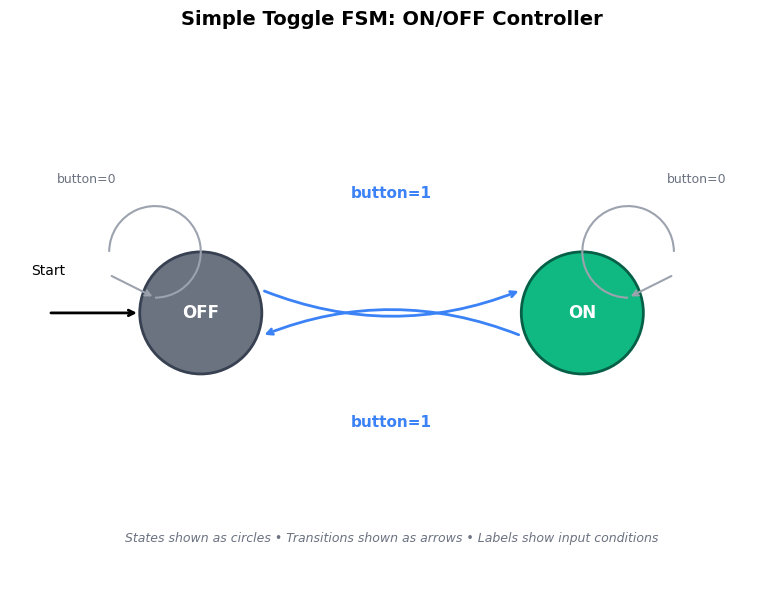

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch, Circle, FancyBboxPatch, Arc
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 100)
ax.set_ylim(0, 70)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Simple Toggle FSM: ON/OFF Controller', fontsize=14, fontweight='bold', pad=15)

# Colors
off_color = '#6b7280'  # gray
on_color = '#10b981'   # green
arrow_color = '#3b82f6'  # blue

# OFF state (left)
off_circle = Circle((25, 35), 8, fill=True, facecolor=off_color, edgecolor='#374151', linewidth=2)
ax.add_patch(off_circle)
ax.text(25, 35, 'OFF', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

# ON state (right)
on_circle = Circle((75, 35), 8, fill=True, facecolor=on_color, edgecolor='#065f46', linewidth=2)
ax.add_patch(on_circle)
ax.text(75, 35, 'ON', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

# Initial state arrow
ax.annotate('', xy=(17, 35), xytext=(5, 35),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.text(5, 40, 'Start', fontsize=10, ha='center')

# Transition: OFF -> ON (button=1)
ax.annotate('', xy=(67, 38), xytext=(33, 38),
            arrowprops=dict(arrowstyle='->', color=arrow_color, lw=2,
                          connectionstyle='arc3,rad=0.2'))
ax.text(50, 50, 'button=1', fontsize=11, ha='center', color=arrow_color, fontweight='bold')

# Transition: ON -> OFF (button=1)
ax.annotate('', xy=(33, 32), xytext=(67, 32),
            arrowprops=dict(arrowstyle='->', color=arrow_color, lw=2,
                          connectionstyle='arc3,rad=0.2'))
ax.text(50, 20, 'button=1', fontsize=11, ha='center', color=arrow_color, fontweight='bold')

# Self-loops for button=0 using Arc patches
# OFF self-loop (top-left)
arc_off = Arc((19, 43), 12, 12, angle=0, theta1=270, theta2=180, color='#9ca3af', lw=1.5)
ax.add_patch(arc_off)
ax.annotate('', xy=(19, 37), xytext=(13, 40),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5))
ax.text(10, 52, 'button=0', fontsize=9, ha='center', color='#6b7280')

# ON self-loop (top-right)
arc_on = Arc((81, 43), 12, 12, angle=0, theta1=0, theta2=270, color='#9ca3af', lw=1.5)
ax.add_patch(arc_on)
ax.annotate('', xy=(81, 37), xytext=(87, 40),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5))
ax.text(90, 52, 'button=0', fontsize=9, ha='center', color='#6b7280')

# Legend
ax.text(50, 5, 'States shown as circles • Transitions shown as arrows • Labels show input conditions',
        ha='center', fontsize=9, style='italic', color='#6b7280')

plt.tight_layout()
plt.show()

This FSM has:
- **2 states**: OFF, ON
- **1 input**: button (0 or 1)
- **Transitions**: Toggle state when button=1, stay in current state when button=0
- **Initial state**: OFF (indicated by the incoming arrow with no source state)

---

## Moore vs Mealy Machines

There are two fundamental types of FSMs, differing in how outputs are determined:

### Moore Machine
- **Output depends only on the current state**
- Output is associated with states
- More states may be needed, but timing is simpler
- Output changes only on clock edges (synchronous)

### Mealy Machine
- **Output depends on current state AND inputs**
- Output is associated with transitions
- Fewer states possible, but more complex timing
- Output can change asynchronously with inputs

Let's visualize both for the same problem: detecting when input X has been 1 for two consecutive clock cycles.

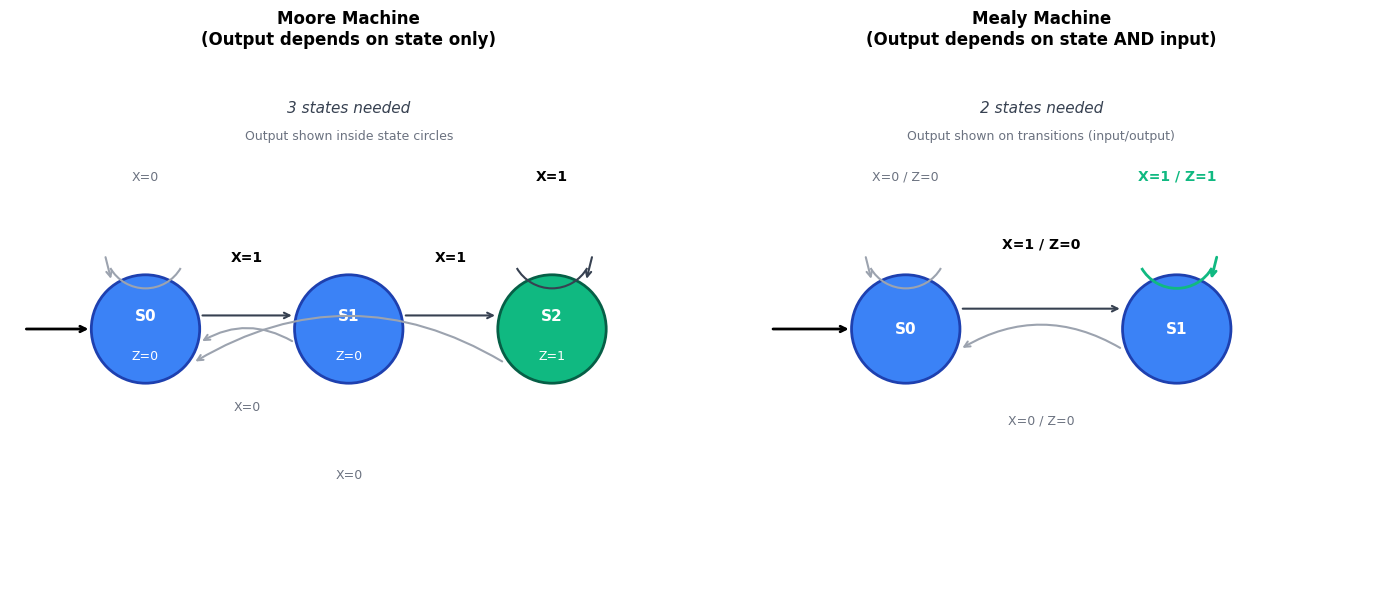

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Colors
state_color = '#3b82f6'
detect_color = '#10b981'
arrow_color = '#374151'

# === MOORE MACHINE (Left) ===
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 80)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('Moore Machine\n(Output depends on state only)', fontsize=12, fontweight='bold', pad=10)

# States for Moore: S0 (idle), S1 (seen one 1), S2 (detected - output=1)
s0 = Circle((20, 40), 8, fill=True, facecolor=state_color, edgecolor='#1e40af', linewidth=2)
ax1.add_patch(s0)
ax1.text(20, 42, 'S0', ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax1.text(20, 36, 'Z=0', ha='center', va='center', fontsize=9, color='white')

s1 = Circle((50, 40), 8, fill=True, facecolor=state_color, edgecolor='#1e40af', linewidth=2)
ax1.add_patch(s1)
ax1.text(50, 42, 'S1', ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax1.text(50, 36, 'Z=0', ha='center', va='center', fontsize=9, color='white')

s2 = Circle((80, 40), 8, fill=True, facecolor=detect_color, edgecolor='#065f46', linewidth=2)
ax1.add_patch(s2)
ax1.text(80, 42, 'S2', ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax1.text(80, 36, 'Z=1', ha='center', va='center', fontsize=9, color='white')

# Initial arrow
ax1.annotate('', xy=(12, 40), xytext=(2, 40),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# S0 -> S1 (X=1)
ax1.annotate('', xy=(42, 42), xytext=(28, 42),
            arrowprops=dict(arrowstyle='->', color=arrow_color, lw=1.5))
ax1.text(35, 50, 'X=1', fontsize=10, ha='center', fontweight='bold')

# S1 -> S2 (X=1)
ax1.annotate('', xy=(72, 42), xytext=(58, 42),
            arrowprops=dict(arrowstyle='->', color=arrow_color, lw=1.5))
ax1.text(65, 50, 'X=1', fontsize=10, ha='center', fontweight='bold')

# S2 -> S2 (X=1) self-loop using Arc
arc_s2 = Arc((80, 52), 12, 12, angle=0, theta1=210, theta2=330, color=arrow_color, lw=1.5)
ax1.add_patch(arc_s2)
ax1.annotate('', xy=(85, 47), xytext=(86, 51),
            arrowprops=dict(arrowstyle='->', color=arrow_color, lw=1.5))
ax1.text(80, 62, 'X=1', fontsize=10, ha='center', fontweight='bold')

# S0 -> S0 (X=0) self-loop
arc_s0 = Arc((20, 52), 12, 12, angle=0, theta1=210, theta2=330, color='#9ca3af', lw=1.5)
ax1.add_patch(arc_s0)
ax1.annotate('', xy=(15, 47), xytext=(14, 51),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5))
ax1.text(20, 62, 'X=0', fontsize=9, ha='center', color='#6b7280')

# S1 -> S0 (X=0)
ax1.annotate('', xy=(28, 38), xytext=(42, 38),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5,
                          connectionstyle='arc3,rad=0.3'))
ax1.text(35, 28, 'X=0', fontsize=9, ha='center', color='#6b7280')

# S2 -> S0 (X=0)
ax1.annotate('', xy=(27, 35), xytext=(73, 35),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5,
                          connectionstyle='arc3,rad=0.3'))
ax1.text(50, 18, 'X=0', fontsize=9, ha='center', color='#6b7280')

ax1.text(50, 72, '3 states needed', fontsize=11, ha='center', style='italic', color='#374151')
ax1.text(50, 68, 'Output shown inside state circles', fontsize=9, ha='center', color='#6b7280')

# === MEALY MACHINE (Right) ===
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 80)
ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title('Mealy Machine\n(Output depends on state AND input)', fontsize=12, fontweight='bold', pad=10)

# States for Mealy: S0 (idle), S1 (seen one 1)
s0m = Circle((30, 40), 8, fill=True, facecolor=state_color, edgecolor='#1e40af', linewidth=2)
ax2.add_patch(s0m)
ax2.text(30, 40, 'S0', ha='center', va='center', fontsize=11, fontweight='bold', color='white')

s1m = Circle((70, 40), 8, fill=True, facecolor=state_color, edgecolor='#1e40af', linewidth=2)
ax2.add_patch(s1m)
ax2.text(70, 40, 'S1', ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# Initial arrow
ax2.annotate('', xy=(22, 40), xytext=(10, 40),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# S0 -> S1 (X=1/Z=0)
ax2.annotate('', xy=(62, 43), xytext=(38, 43),
            arrowprops=dict(arrowstyle='->', color=arrow_color, lw=1.5))
ax2.text(50, 52, 'X=1 / Z=0', fontsize=10, ha='center', fontweight='bold')

# S1 -> S1 (X=1/Z=1) self-loop - detection!
arc_s1m = Arc((70, 52), 12, 12, angle=0, theta1=210, theta2=330, color=detect_color, lw=2)
ax2.add_patch(arc_s1m)
ax2.annotate('', xy=(75, 47), xytext=(76, 51),
            arrowprops=dict(arrowstyle='->', color=detect_color, lw=2))
ax2.text(70, 62, 'X=1 / Z=1', fontsize=10, ha='center', fontweight='bold', color=detect_color)

# S0 -> S0 (X=0/Z=0) self-loop
arc_s0m = Arc((30, 52), 12, 12, angle=0, theta1=210, theta2=330, color='#9ca3af', lw=1.5)
ax2.add_patch(arc_s0m)
ax2.annotate('', xy=(25, 47), xytext=(24, 51),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5))
ax2.text(30, 62, 'X=0 / Z=0', fontsize=9, ha='center', color='#6b7280')

# S1 -> S0 (X=0/Z=0)
ax2.annotate('', xy=(38, 37), xytext=(62, 37),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5,
                          connectionstyle='arc3,rad=0.3'))
ax2.text(50, 26, 'X=0 / Z=0', fontsize=9, ha='center', color='#6b7280')

ax2.text(50, 72, '2 states needed', fontsize=11, ha='center', style='italic', color='#374151')
ax2.text(50, 68, 'Output shown on transitions (input/output)', fontsize=9, ha='center', color='#6b7280')

plt.tight_layout()
plt.show()

**Key observations:**

| Aspect | Moore | Mealy |
|--------|-------|-------|
| States needed | 3 | 2 |
| Output location | Inside states | On transitions |
| Output timing | Changes on clock edge | Can change with input |
| Notation | State/Output | Input/Output on arrows |

The Mealy machine needs fewer states because the output depends on both state AND input, allowing more information per state.

---

## State Tables: The Formal Specification

State diagrams are visual, but state tables provide a complete, unambiguous specification that maps directly to hardware.

### Moore Machine State Table

For the sequence detector Moore machine:

| Current State | X=0 (Next State) | X=1 (Next State) | Output Z |
|--------------|------------------|------------------|----------|
| S0           | S0               | S1               | 0        |
| S1           | S0               | S2               | 0        |
| S2           | S0               | S2               | 1        |

### Mealy Machine State Table

For the Mealy version:

| Current State | X=0 (Next/Out) | X=1 (Next/Out) |
|--------------|----------------|----------------|
| S0           | S0/0           | S1/0           |
| S1           | S0/0           | S1/1           |

The Mealy table is more compact because outputs are specified per transition rather than per state.

---

## State Encoding

To implement an FSM in hardware, we need to assign binary codes to states. The number of flip-flops required is:

$$\text{Number of flip-flops} = \lceil \log_2(\text{number of states}) \rceil$$

For our 3-state Moore machine: $\lceil \log_2(3) \rceil = 2$ flip-flops.

### Common Encoding Schemes

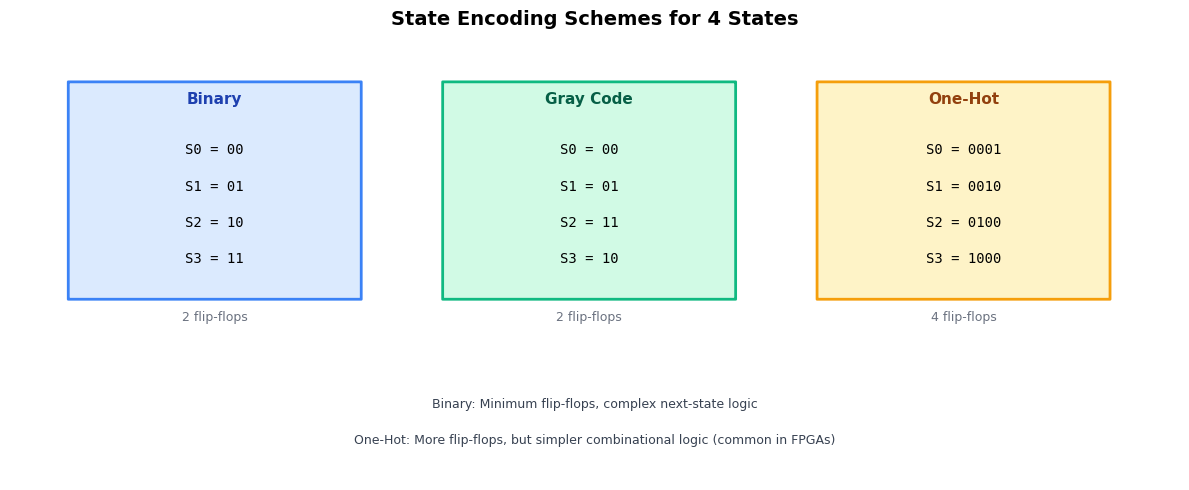

In [3]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.axis('off')
ax.set_xlim(0, 100)
ax.set_ylim(0, 60)
ax.set_title('State Encoding Schemes for 4 States', fontsize=14, fontweight='bold', pad=15)

# Binary encoding
binary_box = FancyBboxPatch((5, 25), 25, 30, boxstyle='round,pad=0.02',
                            facecolor='#dbeafe', edgecolor='#3b82f6', linewidth=2)
ax.add_patch(binary_box)
ax.text(17.5, 52, 'Binary', ha='center', fontsize=11, fontweight='bold', color='#1e40af')
ax.text(17.5, 45, 'S0 = 00', ha='center', fontsize=10, family='monospace')
ax.text(17.5, 40, 'S1 = 01', ha='center', fontsize=10, family='monospace')
ax.text(17.5, 35, 'S2 = 10', ha='center', fontsize=10, family='monospace')
ax.text(17.5, 30, 'S3 = 11', ha='center', fontsize=10, family='monospace')
ax.text(17.5, 22, '2 flip-flops', ha='center', fontsize=9, color='#6b7280')

# Gray code
gray_box = FancyBboxPatch((37, 25), 25, 30, boxstyle='round,pad=0.02',
                          facecolor='#d1fae5', edgecolor='#10b981', linewidth=2)
ax.add_patch(gray_box)
ax.text(49.5, 52, 'Gray Code', ha='center', fontsize=11, fontweight='bold', color='#065f46')
ax.text(49.5, 45, 'S0 = 00', ha='center', fontsize=10, family='monospace')
ax.text(49.5, 40, 'S1 = 01', ha='center', fontsize=10, family='monospace')
ax.text(49.5, 35, 'S2 = 11', ha='center', fontsize=10, family='monospace')
ax.text(49.5, 30, 'S3 = 10', ha='center', fontsize=10, family='monospace')
ax.text(49.5, 22, '2 flip-flops', ha='center', fontsize=9, color='#6b7280')

# One-hot
onehot_box = FancyBboxPatch((69, 25), 25, 30, boxstyle='round,pad=0.02',
                            facecolor='#fef3c7', edgecolor='#f59e0b', linewidth=2)
ax.add_patch(onehot_box)
ax.text(81.5, 52, 'One-Hot', ha='center', fontsize=11, fontweight='bold', color='#92400e')
ax.text(81.5, 45, 'S0 = 0001', ha='center', fontsize=10, family='monospace')
ax.text(81.5, 40, 'S1 = 0010', ha='center', fontsize=10, family='monospace')
ax.text(81.5, 35, 'S2 = 0100', ha='center', fontsize=10, family='monospace')
ax.text(81.5, 30, 'S3 = 1000', ha='center', fontsize=10, family='monospace')
ax.text(81.5, 22, '4 flip-flops', ha='center', fontsize=9, color='#6b7280')

# Trade-offs
ax.text(50, 10, 'Binary: Minimum flip-flops, complex next-state logic', ha='center', fontsize=9, color='#374151')
ax.text(50, 5, 'One-Hot: More flip-flops, but simpler combinational logic (common in FPGAs)', ha='center', fontsize=9, color='#374151')

plt.tight_layout()
plt.show()

**Choosing an encoding:**

- **Binary**: Minimizes flip-flops; good for resource-constrained designs
- **Gray code**: Adjacent states differ by one bit; reduces glitches in outputs
- **One-hot**: One flip-flop per state; simplifies next-state logic, common in FPGAs

---

## Hardware Implementation with D Flip-Flops

Let's implement our Moore sequence detector using D flip-flops and binary encoding:

| State | Q1 Q0 |
|-------|-------|
| S0    | 0  0  |
| S1    | 0  1  |
| S2    | 1  0  |

### Step 1: Encoded State Table

| Q1 | Q0 | X | D1 (Next Q1) | D0 (Next Q0) | Z |
|----|----|---|--------------|--------------|---|
| 0  | 0  | 0 | 0            | 0            | 0 |
| 0  | 0  | 1 | 0            | 1            | 0 |
| 0  | 1  | 0 | 0            | 0            | 0 |
| 0  | 1  | 1 | 1            | 0            | 0 |
| 1  | 0  | 0 | 0            | 0            | 1 |
| 1  | 0  | 1 | 1            | 0            | 1 |
| 1  | 1  | X | -            | -            | - | ← Don't care (unused state)

### Step 2: Derive Boolean Equations

Using Karnaugh maps or inspection:

$$D_1 = Q_0 \cdot X + Q_1 \cdot X = X \cdot (Q_0 + Q_1)$$

$$D_0 = \overline{Q_1} \cdot \overline{Q_0} \cdot X$$

$$Z = Q_1$$

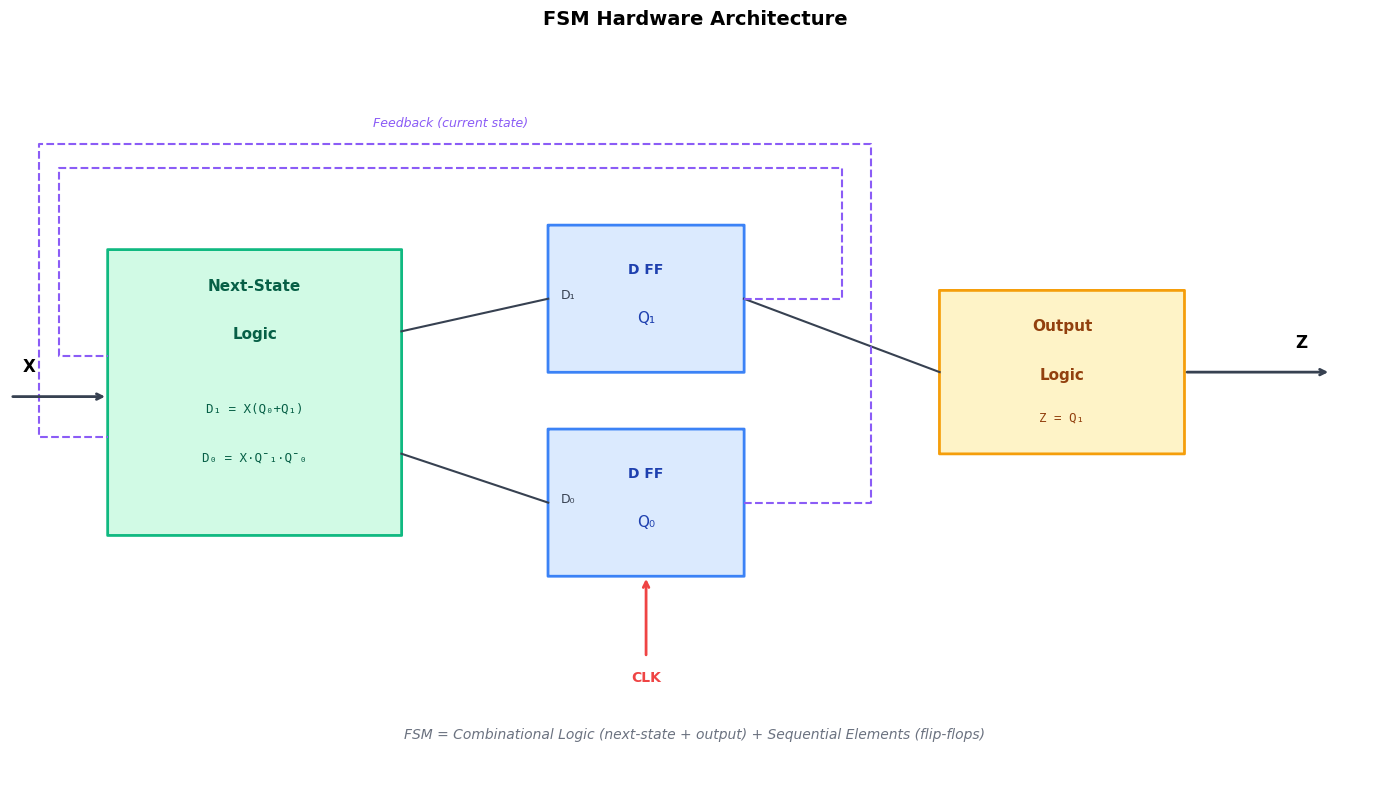

In [4]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('off')
ax.set_xlim(0, 140)
ax.set_ylim(0, 90)
ax.set_title('FSM Hardware Architecture', fontsize=14, fontweight='bold', pad=15)

# Colors
ff_color = '#3b82f6'
logic_color = '#10b981'
wire_color = '#374151'

# Next-state logic box
ns_box = FancyBboxPatch((10, 30), 30, 35, boxstyle='round,pad=0.02',
                        facecolor='#d1fae5', edgecolor=logic_color, linewidth=2)
ax.add_patch(ns_box)
ax.text(25, 60, 'Next-State', ha='center', fontsize=11, fontweight='bold', color='#065f46')
ax.text(25, 54, 'Logic', ha='center', fontsize=11, fontweight='bold', color='#065f46')
ax.text(25, 45, 'D₁ = X(Q₀+Q₁)', ha='center', fontsize=9, family='monospace', color='#065f46')
ax.text(25, 39, 'D₀ = X·Q̄₁·Q̄₀', ha='center', fontsize=9, family='monospace', color='#065f46')

# D Flip-flop 1
ff1_box = FancyBboxPatch((55, 50), 20, 18, boxstyle='round,pad=0.02',
                         facecolor='#dbeafe', edgecolor=ff_color, linewidth=2)
ax.add_patch(ff1_box)
ax.text(65, 62, 'D FF', ha='center', fontsize=10, fontweight='bold', color='#1e40af')
ax.text(65, 56, 'Q₁', ha='center', fontsize=11, color='#1e40af')
ax.text(57, 59, 'D₁', ha='center', fontsize=9, color='#374151')

# D Flip-flop 0
ff0_box = FancyBboxPatch((55, 25), 20, 18, boxstyle='round,pad=0.02',
                         facecolor='#dbeafe', edgecolor=ff_color, linewidth=2)
ax.add_patch(ff0_box)
ax.text(65, 37, 'D FF', ha='center', fontsize=10, fontweight='bold', color='#1e40af')
ax.text(65, 31, 'Q₀', ha='center', fontsize=11, color='#1e40af')
ax.text(57, 34, 'D₀', ha='center', fontsize=9, color='#374151')

# Output logic box
out_box = FancyBboxPatch((95, 40), 25, 20, boxstyle='round,pad=0.02',
                         facecolor='#fef3c7', edgecolor='#f59e0b', linewidth=2)
ax.add_patch(out_box)
ax.text(107.5, 55, 'Output', ha='center', fontsize=11, fontweight='bold', color='#92400e')
ax.text(107.5, 49, 'Logic', ha='center', fontsize=11, fontweight='bold', color='#92400e')
ax.text(107.5, 44, 'Z = Q₁', ha='center', fontsize=9, family='monospace', color='#92400e')

# Input X
ax.annotate('', xy=(10, 47), xytext=(0, 47),
            arrowprops=dict(arrowstyle='->', color=wire_color, lw=2))
ax.text(2, 50, 'X', ha='center', fontsize=12, fontweight='bold')

# Clock
ax.annotate('', xy=(65, 25), xytext=(65, 15),
            arrowprops=dict(arrowstyle='->', color='#ef4444', lw=2))
ax.text(65, 12, 'CLK', ha='center', fontsize=10, color='#ef4444', fontweight='bold')

# Next-state to D inputs
ax.plot([40, 55], [55, 59], color=wire_color, lw=1.5)
ax.plot([40, 55], [40, 34], color=wire_color, lw=1.5)

# Q outputs to output logic
ax.plot([75, 95], [59, 50], color=wire_color, lw=1.5)

# Feedback from Q to next-state logic
ax.plot([75, 85, 85, 5, 5, 10], [59, 59, 75, 75, 52, 52], color='#8b5cf6', lw=1.5, linestyle='--')
ax.plot([75, 88, 88, 3, 3, 10], [34, 34, 78, 78, 42, 42], color='#8b5cf6', lw=1.5, linestyle='--')
ax.text(45, 80, 'Feedback (current state)', ha='center', fontsize=9, color='#8b5cf6', style='italic')

# Output Z
ax.annotate('', xy=(135, 50), xytext=(120, 50),
            arrowprops=dict(arrowstyle='->', color=wire_color, lw=2))
ax.text(132, 53, 'Z', ha='center', fontsize=12, fontweight='bold')

# Labels
ax.text(70, 5, 'FSM = Combinational Logic (next-state + output) + Sequential Elements (flip-flops)',
        ha='center', fontsize=10, style='italic', color='#6b7280')

plt.tight_layout()
plt.show()

### The General FSM Architecture

Every synchronous FSM follows this pattern:

1. **State Register**: Flip-flops store the current state (Q values)
2. **Next-State Logic**: Combinational circuit computing D inputs from current state and inputs
3. **Output Logic**: Combinational circuit computing outputs
   - Moore: Output depends only on Q (current state)
   - Mealy: Output depends on Q and inputs
4. **Clock**: Synchronizes state transitions

---

## Complete Example: Traffic Light Controller

Let's design a simplified traffic light controller for a single intersection. The light cycles through:
- **Green** (30 time units)
- **Yellow** (5 time units)  
- **Red** (30 time units)

For simplicity, we'll use a `timer_done` input signal that goes high when the current phase should end.

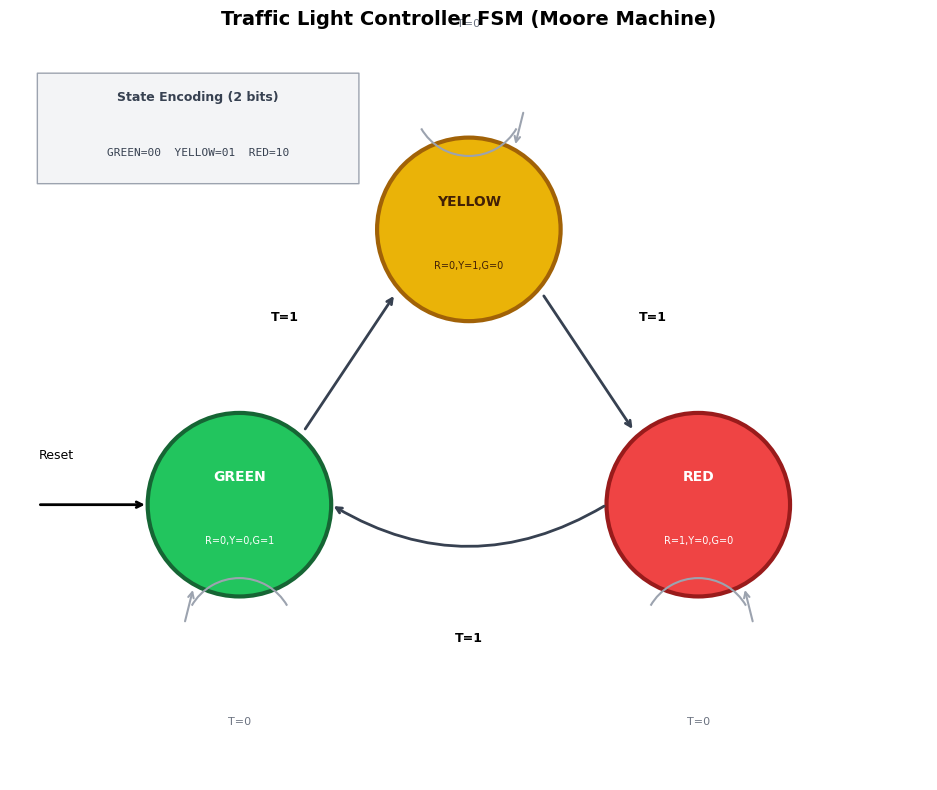

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 100)
ax.set_ylim(0, 80)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Traffic Light Controller FSM (Moore Machine)', fontsize=14, fontweight='bold', pad=15)

# Colors matching traffic lights
green_color = '#22c55e'
yellow_color = '#eab308'
red_color = '#ef4444'

# GREEN state (bottom left)
green_circle = Circle((25, 30), 10, fill=True, facecolor=green_color, edgecolor='#166534', linewidth=3)
ax.add_patch(green_circle)
ax.text(25, 33, 'GREEN', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.text(25, 26, 'R=0,Y=0,G=1', ha='center', va='center', fontsize=7, color='white')

# YELLOW state (top center)
yellow_circle = Circle((50, 60), 10, fill=True, facecolor=yellow_color, edgecolor='#a16207', linewidth=3)
ax.add_patch(yellow_circle)
ax.text(50, 63, 'YELLOW', ha='center', va='center', fontsize=10, fontweight='bold', color='#422006')
ax.text(50, 56, 'R=0,Y=1,G=0', ha='center', va='center', fontsize=7, color='#422006')

# RED state (bottom right)
red_circle = Circle((75, 30), 10, fill=True, facecolor=red_color, edgecolor='#991b1b', linewidth=3)
ax.add_patch(red_circle)
ax.text(75, 33, 'RED', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.text(75, 26, 'R=1,Y=0,G=0', ha='center', va='center', fontsize=7, color='white')

# Initial state arrow
ax.annotate('', xy=(15, 30), xytext=(3, 30),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.text(5, 35, 'Reset', fontsize=9, ha='center')

# GREEN -> YELLOW (timer_done=1)
ax.annotate('', xy=(42, 53), xytext=(32, 38),
            arrowprops=dict(arrowstyle='->', color='#374151', lw=2))
ax.text(30, 50, 'T=1', fontsize=9, ha='center', fontweight='bold')

# YELLOW -> RED (timer_done=1)
ax.annotate('', xy=(68, 38), xytext=(58, 53),
            arrowprops=dict(arrowstyle='->', color='#374151', lw=2))
ax.text(70, 50, 'T=1', fontsize=9, ha='center', fontweight='bold')

# RED -> GREEN (timer_done=1)
ax.annotate('', xy=(35, 30), xytext=(65, 30),
            arrowprops=dict(arrowstyle='->', color='#374151', lw=2,
                          connectionstyle='arc3,rad=-0.3'))
ax.text(50, 15, 'T=1', fontsize=9, ha='center', fontweight='bold')

# Self-loops for timer_done=0 using Arc patches
# GREEN self-loop
arc_g = Arc((25, 16), 12, 12, angle=0, theta1=30, theta2=150, color='#9ca3af', lw=1.5)
ax.add_patch(arc_g)
ax.annotate('', xy=(20, 21), xytext=(19, 17),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5))
ax.text(25, 6, 'T=0', fontsize=8, ha='center', color='#6b7280')

# YELLOW self-loop
arc_y = Arc((50, 74), 12, 12, angle=0, theta1=210, theta2=330, color='#9ca3af', lw=1.5)
ax.add_patch(arc_y)
ax.annotate('', xy=(55, 69), xytext=(56, 73),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5))
ax.text(50, 82, 'T=0', fontsize=8, ha='center', color='#6b7280')

# RED self-loop  
arc_r = Arc((75, 16), 12, 12, angle=0, theta1=30, theta2=150, color='#9ca3af', lw=1.5)
ax.add_patch(arc_r)
ax.annotate('', xy=(80, 21), xytext=(81, 17),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5))
ax.text(75, 6, 'T=0', fontsize=8, ha='center', color='#6b7280')

# State encoding table
table_box = FancyBboxPatch((3, 65), 35, 12, boxstyle='round,pad=0.02',
                           facecolor='#f3f4f6', edgecolor='#9ca3af', linewidth=1)
ax.add_patch(table_box)
ax.text(20.5, 74, 'State Encoding (2 bits)', ha='center', fontsize=9, fontweight='bold', color='#374151')
ax.text(20.5, 68, 'GREEN=00  YELLOW=01  RED=10', ha='center', fontsize=8, family='monospace', color='#374151')

plt.tight_layout()
plt.show()

### State Table for Traffic Light Controller

| Current State | Q1 Q0 | timer_done | Next State | D1 D0 | R | Y | G |
|--------------|-------|------------|------------|-------|---|---|---|
| GREEN        | 0  0  | 0          | GREEN      | 0  0  | 0 | 0 | 1 |
| GREEN        | 0  0  | 1          | YELLOW     | 0  1  | 0 | 0 | 1 |
| YELLOW       | 0  1  | 0          | YELLOW     | 0  1  | 0 | 1 | 0 |
| YELLOW       | 0  1  | 1          | RED        | 1  0  | 0 | 1 | 0 |
| RED          | 1  0  | 0          | RED        | 1  0  | 1 | 0 | 0 |
| RED          | 1  0  | 1          | GREEN      | 0  0  | 1 | 0 | 0 |

### Boolean Equations

From the state table:

$$D_1 = Q_0 \cdot T + Q_1 \cdot \overline{T}$$

$$D_0 = \overline{Q_1} \cdot \overline{Q_0} \cdot T + Q_0 \cdot \overline{T}$$

$$R = Q_1, \quad Y = Q_0, \quad G = \overline{Q_1} \cdot \overline{Q_0}$$

where $T$ = timer_done.

---

## Timing Analysis

Understanding FSM timing is critical for correct operation. Let's trace through our sequence detector:

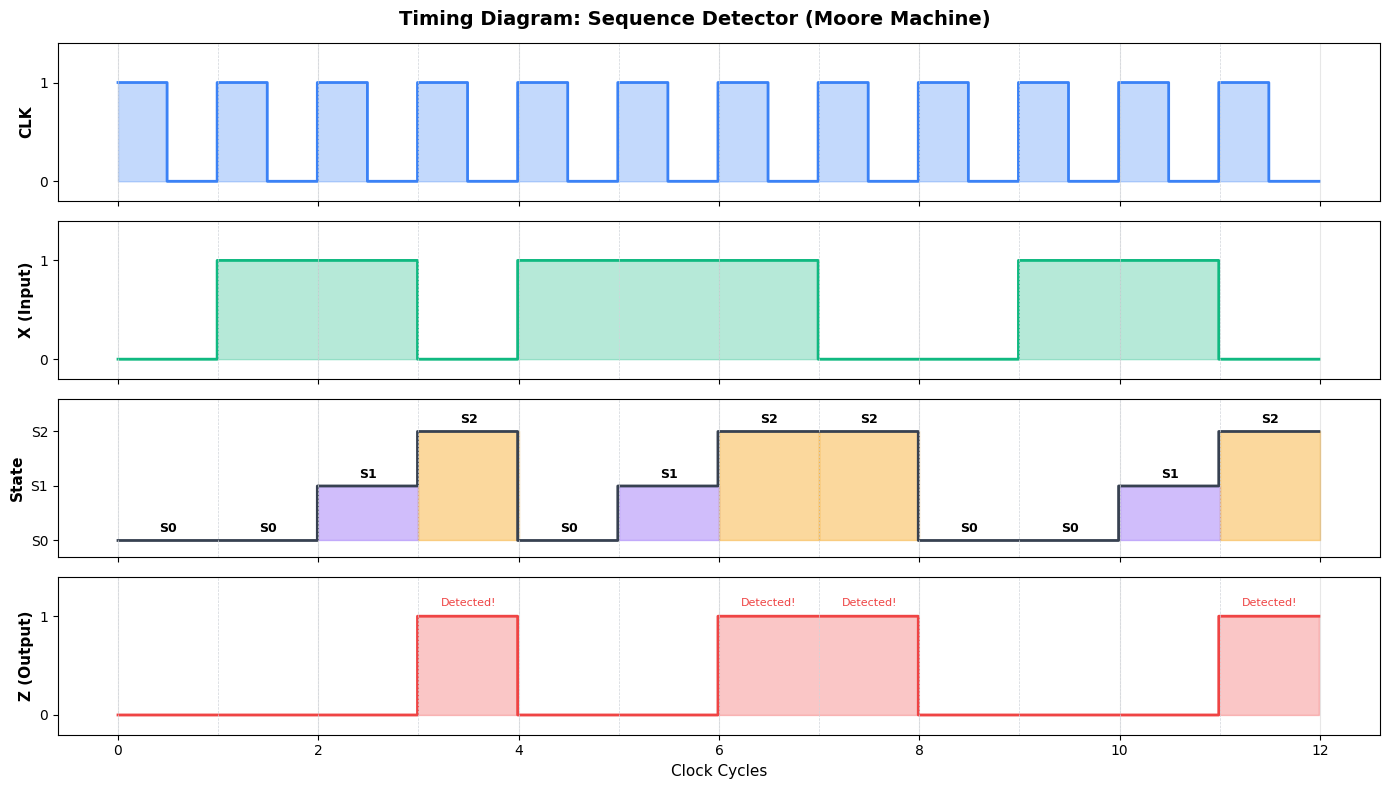

In [6]:
fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
fig.suptitle('Timing Diagram: Sequence Detector (Moore Machine)', fontsize=14, fontweight='bold')

# Time points
t = np.arange(0, 12, 0.01)

# Clock signal
clk = np.zeros_like(t)
for i in range(12):
    clk[(t >= i) & (t < i + 0.5)] = 1

# Input X signal: 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0
x_values = [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0]
x_signal = np.zeros_like(t)
for i, val in enumerate(x_values):
    x_signal[(t >= i) & (t < i + 1)] = val

# State sequence: S0->S0->S1->S2->S0->S1->S2->S2->S0->S0->S1->S2
# State at each clock: after seeing input
state_values = [0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 1, 2]  # 0=S0, 1=S1, 2=S2
state_signal = np.zeros_like(t)
for i, val in enumerate(state_values):
    state_signal[(t >= i) & (t < i + 1)] = val

# Output Z (Moore: depends only on state)
z_signal = np.zeros_like(t)
for i, val in enumerate(state_values):
    z_signal[(t >= i) & (t < i + 1)] = 1 if val == 2 else 0

# Plot clock
axes[0].fill_between(t, 0, clk, color='#3b82f6', alpha=0.3, step='pre')
axes[0].plot(t, clk, color='#3b82f6', lw=2, drawstyle='steps-pre')
axes[0].set_ylabel('CLK', fontsize=11, fontweight='bold')
axes[0].set_ylim(-0.2, 1.4)
axes[0].set_yticks([0, 1])
axes[0].grid(True, alpha=0.3, axis='x')

# Plot X
axes[1].fill_between(t, 0, x_signal, color='#10b981', alpha=0.3, step='pre')
axes[1].plot(t, x_signal, color='#10b981', lw=2, drawstyle='steps-pre')
axes[1].set_ylabel('X (Input)', fontsize=11, fontweight='bold')
axes[1].set_ylim(-0.2, 1.4)
axes[1].set_yticks([0, 1])
axes[1].grid(True, alpha=0.3, axis='x')

# Plot State
colors = ['#6b7280', '#8b5cf6', '#f59e0b']
labels = ['S0', 'S1', 'S2']
axes[2].plot(t, state_signal, color='#374151', lw=2, drawstyle='steps-pre')
for i in range(12):
    state = state_values[i]
    axes[2].fill_between([i, i+1], 0, state, color=colors[state], alpha=0.4, step='pre')
    axes[2].text(i + 0.5, state + 0.15, labels[state], ha='center', fontsize=9, fontweight='bold')
axes[2].set_ylabel('State', fontsize=11, fontweight='bold')
axes[2].set_ylim(-0.3, 2.6)
axes[2].set_yticks([0, 1, 2])
axes[2].set_yticklabels(['S0', 'S1', 'S2'])
axes[2].grid(True, alpha=0.3, axis='x')

# Plot Z
axes[3].fill_between(t, 0, z_signal, color='#ef4444', alpha=0.3, step='pre')
axes[3].plot(t, z_signal, color='#ef4444', lw=2, drawstyle='steps-pre')
axes[3].set_ylabel('Z (Output)', fontsize=11, fontweight='bold')
axes[3].set_ylim(-0.2, 1.4)
axes[3].set_yticks([0, 1])
axes[3].set_xlabel('Clock Cycles', fontsize=11)
axes[3].grid(True, alpha=0.3, axis='x')

# Add clock edge markers
for i in range(12):
    for ax in axes:
        ax.axvline(x=i, color='#d1d5db', linestyle='--', lw=0.5)

# Highlight detections
for i in [3, 6, 7, 11]:
    axes[3].annotate('Detected!', xy=(i + 0.5, 1.1), fontsize=8, ha='center', color='#ef4444')

plt.tight_layout()
plt.show()

**Reading the timing diagram:**

1. State changes occur at the **rising edge** of the clock
2. The new state depends on the **current state** and **input at the clock edge**
3. In a Moore machine, output Z changes only when the state changes
4. Detection (Z=1) occurs when we reach state S2, which happens after seeing two consecutive 1s

---

## Common FSM Design Patterns

### Pattern 1: Sequence Detector
Detects a specific bit pattern in a stream. We built one above.

### Pattern 2: Counter
Cycles through states in order. Each state represents a count value.

### Pattern 3: Controller
Orchestrates multi-step operations. States represent phases of an operation (like the traffic light).

### Pattern 4: Arbiter
Manages access to shared resources. States track which requester has access.

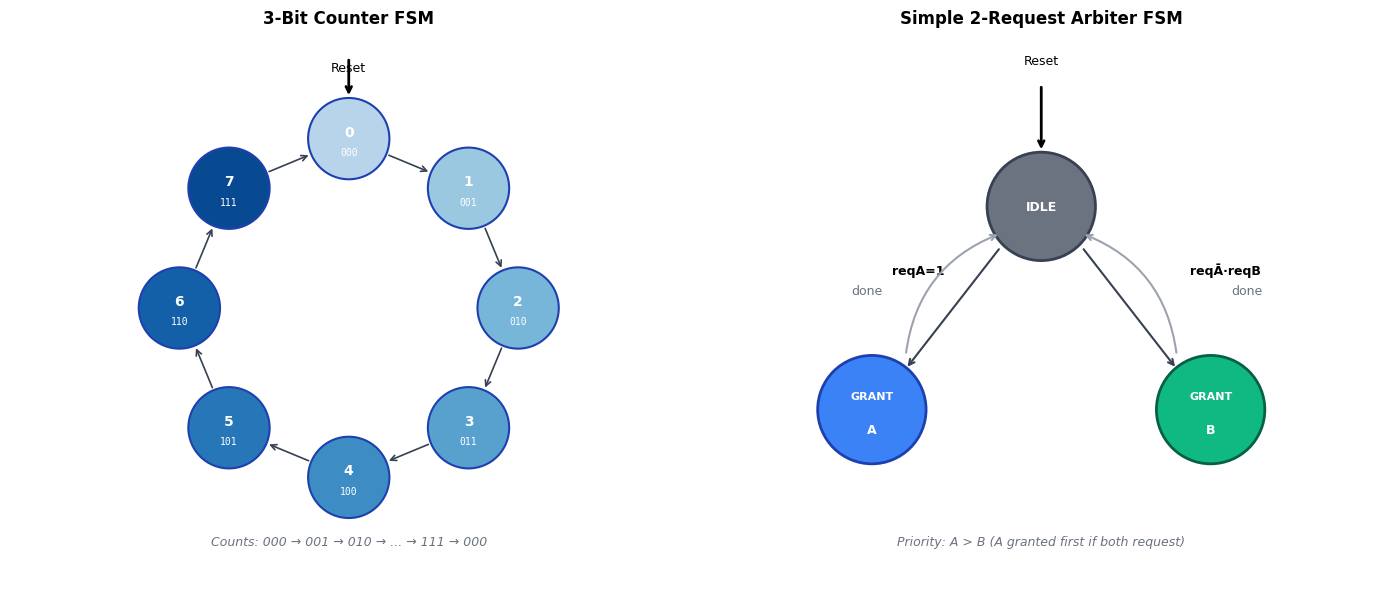

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# === 3-bit Counter (Left) ===
ax1 = axes[0]
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 80)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('3-Bit Counter FSM', fontsize=12, fontweight='bold', pad=10)

# Arrange states in a circle
n_states = 8
center_x, center_y = 50, 40
radius = 25
state_radius = 6

colors = plt.cm.Blues(np.linspace(0.3, 0.9, n_states))

positions = []
for i in range(n_states):
    angle = np.pi/2 - i * 2 * np.pi / n_states
    x = center_x + radius * np.cos(angle)
    y = center_y + radius * np.sin(angle)
    positions.append((x, y))
    
    circle = Circle((x, y), state_radius, fill=True, facecolor=colors[i], 
                    edgecolor='#1e40af', linewidth=1.5)
    ax1.add_patch(circle)
    ax1.text(x, y + 1, f'{i}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    ax1.text(x, y - 2, f'{i:03b}', ha='center', va='center', fontsize=7, color='white', family='monospace')

# Draw arrows between consecutive states
for i in range(n_states):
    next_i = (i + 1) % n_states
    x1, y1 = positions[i]
    x2, y2 = positions[next_i]
    
    # Calculate arrow positions (on edge of circles)
    angle = np.arctan2(y2 - y1, x2 - x1)
    start_x = x1 + state_radius * np.cos(angle)
    start_y = y1 + state_radius * np.sin(angle)
    end_x = x2 - state_radius * np.cos(angle)
    end_y = y2 - state_radius * np.sin(angle)
    
    ax1.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                arrowprops=dict(arrowstyle='->', color='#374151', lw=1.2))

# Initial arrow to state 0
ax1.annotate('', xy=(positions[0][0], positions[0][1] + state_radius),
            xytext=(positions[0][0], positions[0][1] + state_radius + 6),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax1.text(positions[0][0], 75, 'Reset', ha='center', fontsize=9)

ax1.text(50, 5, 'Counts: 000 → 001 → 010 → ... → 111 → 000', 
        ha='center', fontsize=9, style='italic', color='#6b7280')

# === Simple Arbiter (Right) ===
ax2 = axes[1]
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 80)
ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title('Simple 2-Request Arbiter FSM', fontsize=12, fontweight='bold', pad=10)

# States
idle = Circle((50, 55), 8, fill=True, facecolor='#6b7280', edgecolor='#374151', linewidth=2)
ax2.add_patch(idle)
ax2.text(50, 55, 'IDLE', ha='center', va='center', fontsize=9, fontweight='bold', color='white')

grant_a = Circle((25, 25), 8, fill=True, facecolor='#3b82f6', edgecolor='#1e40af', linewidth=2)
ax2.add_patch(grant_a)
ax2.text(25, 27, 'GRANT', ha='center', va='center', fontsize=8, fontweight='bold', color='white')
ax2.text(25, 22, 'A', ha='center', va='center', fontsize=9, fontweight='bold', color='white')

grant_b = Circle((75, 25), 8, fill=True, facecolor='#10b981', edgecolor='#065f46', linewidth=2)
ax2.add_patch(grant_b)
ax2.text(75, 27, 'GRANT', ha='center', va='center', fontsize=8, fontweight='bold', color='white')
ax2.text(75, 22, 'B', ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Initial arrow
ax2.annotate('', xy=(50, 63), xytext=(50, 73),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax2.text(50, 76, 'Reset', ha='center', fontsize=9)

# IDLE -> GRANT_A (reqA=1)
ax2.annotate('', xy=(30, 31), xytext=(44, 49),
            arrowprops=dict(arrowstyle='->', color='#374151', lw=1.5))
ax2.text(28, 45, 'reqA=1', fontsize=9, fontweight='bold')

# IDLE -> GRANT_B (reqA=0, reqB=1)
ax2.annotate('', xy=(70, 31), xytext=(56, 49),
            arrowprops=dict(arrowstyle='->', color='#374151', lw=1.5))
ax2.text(72, 45, 'reqĀ·reqB', fontsize=9, fontweight='bold')

# GRANT_A -> IDLE (done)
ax2.annotate('', xy=(44, 51), xytext=(30, 33),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5,
                          connectionstyle='arc3,rad=-0.3'))
ax2.text(22, 42, 'done', fontsize=9, color='#6b7280')

# GRANT_B -> IDLE (done)
ax2.annotate('', xy=(56, 51), xytext=(70, 33),
            arrowprops=dict(arrowstyle='->', color='#9ca3af', lw=1.5,
                          connectionstyle='arc3,rad=0.3'))
ax2.text(78, 42, 'done', fontsize=9, color='#6b7280')

ax2.text(50, 5, 'Priority: A > B (A granted first if both request)', 
        ha='center', fontsize=9, style='italic', color='#6b7280')

plt.tight_layout()
plt.show()

---

## Key Takeaways

1. **FSMs are the foundation** of sequential digital design — nearly every digital system contains FSMs

2. **Moore vs Mealy** is a fundamental design choice:
   - Moore: Simpler timing, outputs change only on clock edges
   - Mealy: Potentially fewer states, faster response to inputs

3. **State encoding** affects implementation complexity:
   - Binary minimizes flip-flops
   - One-hot simplifies combinational logic

4. **The general architecture** is always:
   - State register (flip-flops)
   - Next-state combinational logic
   - Output combinational logic

5. **Design process**:
   1. Draw state diagram from requirements
   2. Create state table
   3. Choose state encoding
   4. Derive Boolean equations
   5. Implement with gates and flip-flops (or HDL)

---

*FSMs are everywhere in digital design — from simple button debouncers to complex CPU control units. Master them, and you have a powerful tool for any sequential logic problem.*